## Loading Dependencies

In [46]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/NetworkScience")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper Functions

In [47]:
def load_dataset(path, routes=True):
  """
  Creates dataframe with all routes from a .csv file
  :param path: Str. Path to a .csv file containing the fligth data
  :param routes: Bool. If true returns set of routes in the data
  :return: Dataframe with all routes flown
  """

  # Extracting year
  year = int(path[-8:-4])

  # Creating the dataframe
  df = pd.read_csv(path)

  # Create "Route" column
  df["Route"] = df["ORIGIN_CITY_NAME"] + ";" + df["DEST_CITY_NAME"]

  # Aggregation
  df_agg = df.groupby("Route", as_index=False).mean(numeric_only=True)

  df_agg[["Origin", "Destination"]] = df_agg["Route"].str.split(";",
                                                                n=1,
                                                                expand=True)

  # Creating year column
  df_agg["Year"] = year

  # Renaming columns
  df_agg = df_agg.rename(columns={"ARR_DELAY": "Delay",
                                  "DISTANCE": "Distance"})

  # Replacing NaNs
  df_agg["Delay"].fillna(df_agg["Delay"].mean(),
                         inplace=True)

  # Selecting columns
  df_agg = df_agg[["Route",
                   "Origin",
                   "Destination",
                   "Delay",
                   "Distance",
                   "Year"]]

  if routes:
    # Creating set of all routes in the dataframe
    routes = set(df_agg["Route"])

    return df_agg, routes

  return df_agg



def create_digraph(df):
  """
  Creates directed graph from a dataframe
  :param df: Dataframe to create graph from
  :return: nx DiGraph object
  """
  G = nx.DiGraph()

  for i in range(len(df)):
    G.add_edge(df["Origin"].iloc[i,], df["Destination"].iloc[i,],
               year=df["Year"].iloc[i,],
               delay=df["Delay"].iloc[i,],
               distance=df["Distance"].iloc[i,])

  return G



def create_graph(df, excluded_routes=None):
  """
  Creates undirected graph from a dataframe
  :param df: Dataframe to create graph from
  :param excluded_routes: Set of routes not to include in the graph
  :return: nx Graph object
  """
  G = nx.DiGraph()

  if excluded_routes:
    for i in range(len(df)):
       if df["Route"].iloc[i,] not in excluded_routes:

        G.add_edge(df["Origin"].iloc[i,], df["Destination"].iloc[i,],
                  year=df["Year"].iloc[i,],
                  delay=df["Delay"].iloc[i,],
                  distance=df["Distance"].iloc[i,])

  else:
    for i in range(len(df)):

      G.add_edge(df["Origin"].iloc[i,], df["Destination"].iloc[i,],
                 year=df["Year"].iloc[i,],
                 delay=df["Delay"].iloc[i,],
                 distance=df["Distance"].iloc[i,])

  G = G.to_undirected()

  return G



def create_link_prediction_data(training_graph, testing_graph):
  """
  Feature matrix and label vector for link prediction
  :param training_graph: nx Graph object of the training graph
  :param testing_graph: nx Graph object of the testing graph
  :return: Feature matrix and label vector
  """

  # List of all edges in the testing graph
  edge_list = np.array([{u,v} for u,v in testing_graph.edges()])

  # List of all tuples of nodes for which a new link has formed
  positive_datapoints = [(u, v) for u, v in edge_list
                         if training_graph.has_node(u)
                         and training_graph.has_node(v)]

  print(f"Number of newly formed links: {len(positive_datapoints)}")

  # List of tuples where no link has formed
  negative_datapoints = []
  testing_nodes = list(testing_graph.nodes())
  count = 0
  while count < len(positive_datapoints):
    u, v = np.random.choice(testing_nodes, size=2, replace=False)
    if (not training_graph.has_edge(u, v) and training_graph.has_node(u)
    and training_graph.has_node(v)):
        negative_datapoints.append((u, v))
        count += 1

  # Creating the dataframe
  df_link_prediction =  pd.DataFrame()
  datapoints =  positive_datapoints + negative_datapoints

  # Feature engineering
  df_link_prediction["jaccard"] = [j for _, _, j in nx.jaccard_coefficient(training_graph, datapoints)]
  df_link_prediction["rai"] = [j for _, _, j in nx.resource_allocation_index(training_graph, datapoints)]
  df_link_prediction["aai"] = [j for _, _, j in nx.adamic_adar_index(training_graph, datapoints)]
  df_link_prediction["pref"] = [j for _, _, j in nx.preferential_attachment(training_graph, datapoints)]
  df_link_prediction["cnc"] = [j for _, _, j in nx.common_neighbor_centrality(training_graph, datapoints)]
  df_link_prediction["label"] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]

  # Feature matrix label vector
  X = df_link_prediction[["jaccard", "rai", "aai", "pref", "cnc"]]
  y = df_link_prediction["label"]

  return X, y

## Creating the Graphs

In [48]:
df_2023, _ = load_dataset("/content/drive/MyDrive/NetworkScience/flight_data/flights_2023.csv")

G = create_graph(df_2023)
G_directed = create_digraph(df_2023)

In [49]:
print(f"Undirected Graph: {G}\n")
print(f"Directed Graph: {G_directed}")

Undirected Graph: Graph with 333 nodes and 2584 edges

Directed Graph: DiGraph with 333 nodes and 5155 edges


## Degree Distribution

### Degree Analysis


Degrees

In [50]:
degrees = dict(G.degree)
# Average degree
avg_degree = np.mean(list(degrees.values()))

# Median degree
median_degree = np.median(list(degrees.values()))

# Max degree and nodes
max_degree = max(degrees.values())
max_nodes = [k for k, v in degrees.items() if v == max_degree]

# Min degree and nodes
min_degree = min(degrees.values())
min_nodes = [k for k, v in degrees.items() if v == min_degree]

# Standard deviation
sd_degree = np.std(list(degrees.values()))

print(f"Average Degree: {avg_degree:.2f} \n"
f"Median Degree: {int(median_degree)} \n"
f"Maximum Degree: {max_degree} (City: {max_nodes[0]})\n"
f"Minimum Degree: {min_degree} (City: {min_nodes[0]}, etc.)\n"
f"Degree Standard Deviation: {sd_degree:.2f}")

Average Degree: 15.52 
Median Degree: 5 
Maximum Degree: 175 (City: Dallas/Fort Worth, TX)
Minimum Degree: 1 (City: Aberdeen, SD, etc.)
Degree Standard Deviation: 26.69


### Top 5 degree nodes

In [51]:
degrees_sorted = sorted(dict(G.degree).items(),
                        key=lambda x:x[1],
                        reverse=True)

for i in range (15):

  print(f"{degrees_sorted[i][0]}: {degrees_sorted[i][1]}")

Dallas/Fort Worth, TX: 175
Denver, CO: 154
Chicago, IL: 150
Atlanta, GA: 143
Phoenix, AZ: 122
Las Vegas, NV: 116
Charlotte, NC: 115
Washington, DC: 98
Houston, TX: 97
New York, NY: 96
Minneapolis, MN: 95
Los Angeles, CA: 87
Detroit, MI: 86
Newark, NJ: 81
Orlando, FL: 79


In-degrees

In [52]:
in_degrees = dict(G_directed.in_degree)
# Average degree
avg_in_degree = np.mean(list(in_degrees.values()))

# Max degree and nodes
max_in_degree = max(in_degrees.values())
max_in_nodes = [k for k, v in in_degrees.items() if v == max_in_degree]

# Min degree and nodes
min_in_degree = min(in_degrees.values())
min_in_nodes = [k for k, v in in_degrees.items() if v == min_in_degree]

# Standard deviation
sd_in_degree = np.std(list(in_degrees.values()))

print(f"Average In-Degree: {avg_in_degree:.2f} \n"
f"Maximum In-Degree: {max_in_degree} (City: {max_in_nodes[0]})\n"
f"Minimum In-Degree: {min_in_degree} (City: {min_in_nodes[0]}, etc.)\n"
f"In-Degree Standard Deviation: {sd_in_degree:.2f}")

Average In-Degree: 15.48 
Maximum In-Degree: 175 (City: Dallas/Fort Worth, TX)
Minimum In-Degree: 1 (City: Aberdeen, SD, etc.)
In-Degree Standard Deviation: 26.64


Out-degrees

In [53]:
out_degrees = dict(G_directed.out_degree)
# Average degree
avg_out_degree = np.mean(list(out_degrees.values()))

# Max degree and nodes
max_out_degree = max(out_degrees.values())
max_out_nodes = [k for k, v in out_degrees.items() if v == max_out_degree]

# Min degree and nodes
min_out_degree = min(out_degrees.values())
min_out_nodes = [k for k, v in out_degrees.items() if v == min_out_degree]

# Standard deviation
sd_out_degree = np.std(list(out_degrees.values()))

print(f"Average Out-Degree: {avg_out_degree:.2f} \n"
f"Maximum Out-Degree: {max_out_degree} (City: {max_out_nodes[0]})\n"
f"Minimum Out-Degree: {min_out_degree} (City: {min_out_nodes[0]}, etc.)\n"
f"Out-Degree Standard Deviation: {sd_out_degree:.2f}")

Average Out-Degree: 15.48 
Maximum Out-Degree: 175 (City: Dallas/Fort Worth, TX)
Minimum Out-Degree: 1 (City: Aberdeen, SD, etc.)
Out-Degree Standard Deviation: 26.63


Weight-degrees

In [54]:
weight_degrees = dict(G.degree(weight="delay"))
# Average degree
avg_weight_degree = np.mean(list(weight_degrees.values()))

# Max degree and nodes
max_weight_degree = max(weight_degrees.values())
max_weight_nodes = [k for k, v in weight_degrees.items() if v == max_weight_degree]

# Min degree and nodes
min_weight_degree = min(weight_degrees.values())
min_weight_nodes = [k for k, v in weight_degrees.items() if v == min_weight_degree]

# Standard deviation
sd_weight_degree = np.std(list(weight_degrees.values()))

print(f"Average Weight-Degree: {avg_weight_degree:.2f} \n"
f"Maximum Weight-Degree: {max_weight_degree:.2f} (City: {max_weight_nodes[0]})\n"
f"Minimum Weight-Degree: {min_weight_degree:.2f} (City: {min_weight_nodes[0]}, etc.)\n"
f"Weight-Degree Standard Deviation: {sd_weight_degree:.2f}")

Average Weight-Degree: 178.31 
Maximum Weight-Degree: 2340.24 (City: Dallas/Fort Worth, TX)
Minimum Weight-Degree: -43.65 (City: Juneau, AK, etc.)
Weight-Degree Standard Deviation: 368.44


In [55]:
out_degrees = dict(G_directed.out_degree(weight="delay"))
# Average degree
avg_out_degree = np.mean(list(out_degrees.values()))

# Max degree and nodes
max_out_degree = max(out_degrees.values())
max_out_nodes = [k for k, v in out_degrees.items() if v == max_out_degree]

# Min degree and nodes
min_out_degree = min(out_degrees.values())
min_out_nodes = [k for k, v in out_degrees.items() if v == min_out_degree]

# Standard deviation
sd_out_degree = np.std(list(out_degrees.values()))

print(f"Average Out-Degree: {avg_out_degree:.2f} \n"
f"Maximum Out-Degree: {max_out_degree} (City: {max_out_nodes[0]})\n"
f"Minimum Out-Degree: {min_out_degree} (City: {min_out_nodes[0]}, etc.)\n"
f"Out-Degree Standard Deviation: {sd_out_degree:.2f}")

Average Out-Degree: 161.69 
Maximum Out-Degree: 2669.1981585928515 (City: Denver, CO)
Minimum Out-Degree: -37.10814417004381 (City: Allentown/Bethlehem/Easton, PA, etc.)
Out-Degree Standard Deviation: 329.70


In [56]:
in_degrees = dict(G_directed.in_degree(weight="delay"))
# Average degree
avg_in_degree = np.mean(list(in_degrees.values()))

# Max degree and nodes
max_in_degree = max(in_degrees.values())
max_in_nodes = [k for k, v in in_degrees.items() if v == max_in_degree]

# Min degree and nodes
min_in_degree = min(in_degrees.values())
min_in_nodes = [k for k, v in in_degrees.items() if v == min_in_degree]

# Standard deviation
sd_in_degree = np.std(list(in_degrees.values()))

print(f"Average In-Degree: {avg_in_degree:.2f} \n"
f"Maximum In-Degree: {max_in_degree} (City: {max_in_nodes[0]})\n"
f"Minimum In-Degree: {min_in_degree} (City: {min_in_nodes[0]}, etc.)\n"
f"In-Degree Standard Deviation: {sd_in_degree:.2f}")

Average In-Degree: 161.69 
Maximum In-Degree: 2345.880026428104 (City: Dallas/Fort Worth, TX)
Minimum In-Degree: -158.56066009123734 (City: Seattle, WA, etc.)
In-Degree Standard Deviation: 365.66


Worst and Best Connections

In [57]:
max(dict(G_directed.edges).items(), key=lambda x: x[1]['delay'])

(('Boston, MA', 'Valparaiso, FL'),
 {'year': 2023, 'delay': 1525.0, 'distance': 1187.0})

In [58]:
min(dict(G_directed.edges).items(), key=lambda x: x[1]['delay'])

(('Peoria, IL', 'Denver, CO'),
 {'year': 2023, 'delay': -36.0, 'distance': 793.0})

### Degree Distriubtion Plots

In [59]:
# Degree Count
degree_count = list(nx.degree_histogram(G))

# Degree Probabilities
p_k = degree_count / np.sum(degree_count)


# Random Network
random_network = nx.erdos_renyi_graph(G.order(), nx.density(G))

# Random Network Degree Count
random_degree_count = list(nx.degree_histogram(random_network))

# Random Network Degree Probabilities
p_k_random = random_degree_count / np.sum(random_degree_count)

In [60]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

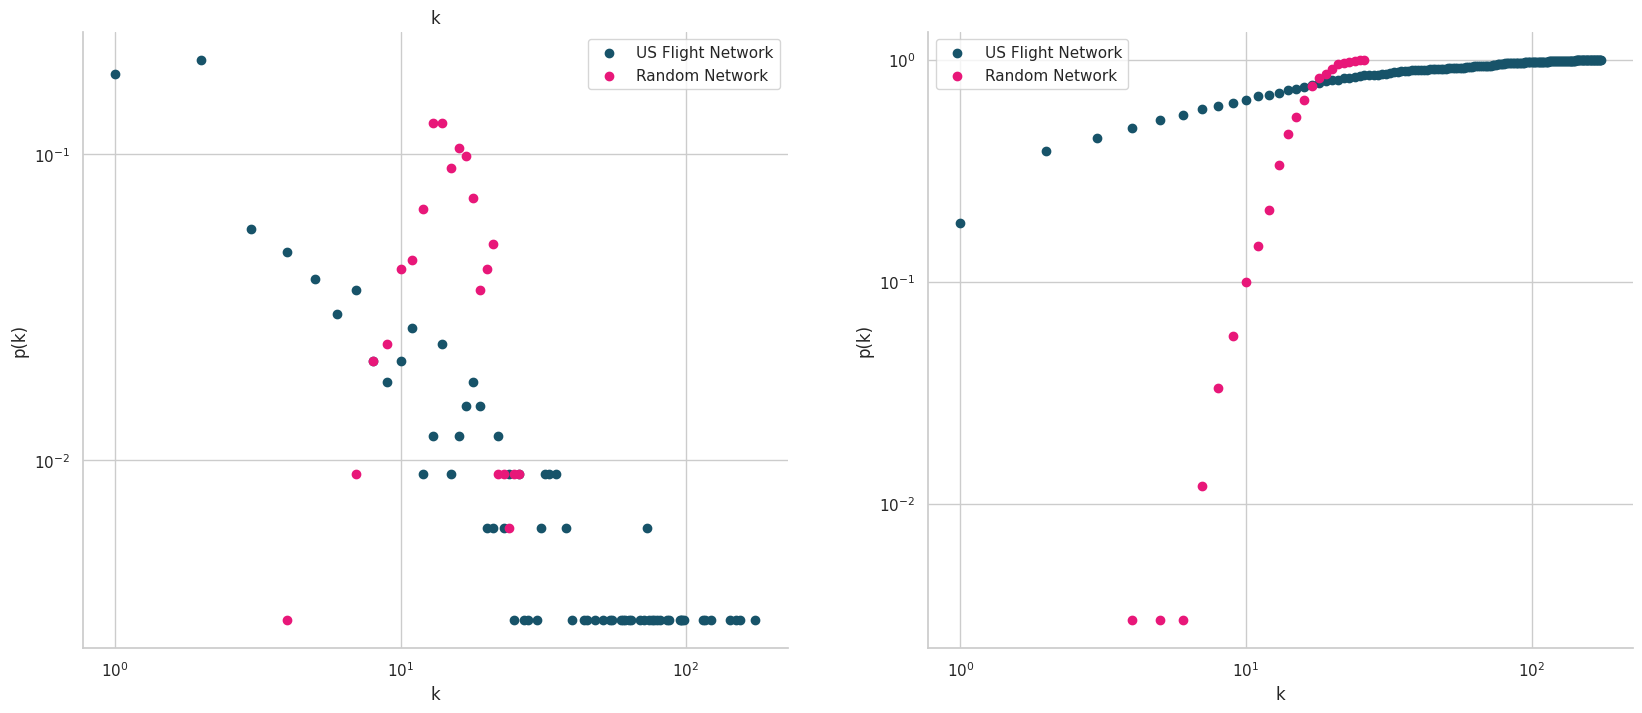

In [61]:
fig, ax = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

ax[0].scatter(x=range(len(p_k)), y=p_k, marker="o", color="#175369")
ax[0].scatter(x=range(len(p_k_random)), y=p_k_random, marker="o", color="#e81779")
ax[0].legend(["US Flight Network", "Random Network"])

ax[0].set_title("k")
ax[0].set_xlabel("k")
ax[0].set_ylabel("p(k)")
ax[0].set_xscale("log")
ax[0].set_yscale("log")


ax[1].scatter(x=range(len(p_k)), y=np.cumsum(p_k), marker="o", color="#175369")
ax[1].scatter(x=range(len(p_k_random)), y=np.cumsum(p_k_random), marker="o", color="#e81779")
ax[1].legend(["US Flight Network", "Random Network"])

ax[1].set_xlabel("k")
ax[1].set_ylabel("p(k)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

plt.show()

## Density

In [62]:
density = nx.density(G)
print(f"Density: {density:.4f}")

Density: 0.0467


## Diameter

In [63]:
diameter = nx.diameter(G)
print(f"Diameter: {diameter}")

Diameter: 5


## Connectivity

In [64]:
nx.is_weakly_connected(G_directed)

True

In [65]:
nx.is_strongly_connected(G_directed)

True

## Centrality

In [66]:
degree_centrality = sorted(nx.degree_centrality(G).items(),
                           reverse=True,
                           key=lambda x:x[1])

for i in range(10):
  print(f"{degree_centrality[i][0]}: {degree_centrality[i][1]:.2f}")

Dallas/Fort Worth, TX: 0.53
Denver, CO: 0.46
Chicago, IL: 0.45
Atlanta, GA: 0.43
Phoenix, AZ: 0.37
Las Vegas, NV: 0.35
Charlotte, NC: 0.35
Washington, DC: 0.30
Houston, TX: 0.29
New York, NY: 0.29


In [67]:
eigenvector_centrality = sorted(nx.eigenvector_centrality(G).items(),
                                reverse=True,
                                key=lambda x:x[1])

for i in range(10):
  print(f"{eigenvector_centrality[i][0]}: {eigenvector_centrality[i][1]:.2f}")

Dallas/Fort Worth, TX: 0.20
Chicago, IL: 0.19
Atlanta, GA: 0.19
Denver, CO: 0.19
Charlotte, NC: 0.17
Las Vegas, NV: 0.17
Phoenix, AZ: 0.17
Houston, TX: 0.17
Washington, DC: 0.16
New York, NY: 0.16


In [68]:
closeness_centrality = sorted(nx.closeness_centrality(G).items(),
                              reverse=True,
                              key=lambda x:x[1])

for i in range(10):
  print(f"{closeness_centrality[i][0]}: {closeness_centrality[i][1]:.2f}")

Dallas/Fort Worth, TX: 0.66
Denver, CO: 0.64
Chicago, IL: 0.64
Atlanta, GA: 0.61
Phoenix, AZ: 0.60
Las Vegas, NV: 0.59
Charlotte, NC: 0.58
Minneapolis, MN: 0.58
Washington, DC: 0.57
Houston, TX: 0.57


In [69]:
betweenness_centrality = sorted(nx.betweenness_centrality(G).items(),
                                reverse=True,
                                key=lambda x:x[1])

for i in range(10):
  print(f"{betweenness_centrality[i][0]}: {betweenness_centrality[i][1]:.2f}")

Dallas/Fort Worth, TX: 0.21
Denver, CO: 0.17
Chicago, IL: 0.13
Atlanta, GA: 0.09
Minneapolis, MN: 0.07
Phoenix, AZ: 0.06
Anchorage, AK: 0.05
Detroit, MI: 0.05
Las Vegas, NV: 0.05
Charlotte, NC: 0.05


### Correlation

In [70]:
centralities = [list(nx.degree_centrality(G).values()),
                list(nx.eigenvector_centrality(G).values()),
                list(nx.closeness_centrality(G).values()),
                list(nx.betweenness_centrality(G).values())]

corr = np.corrcoef(centralities)

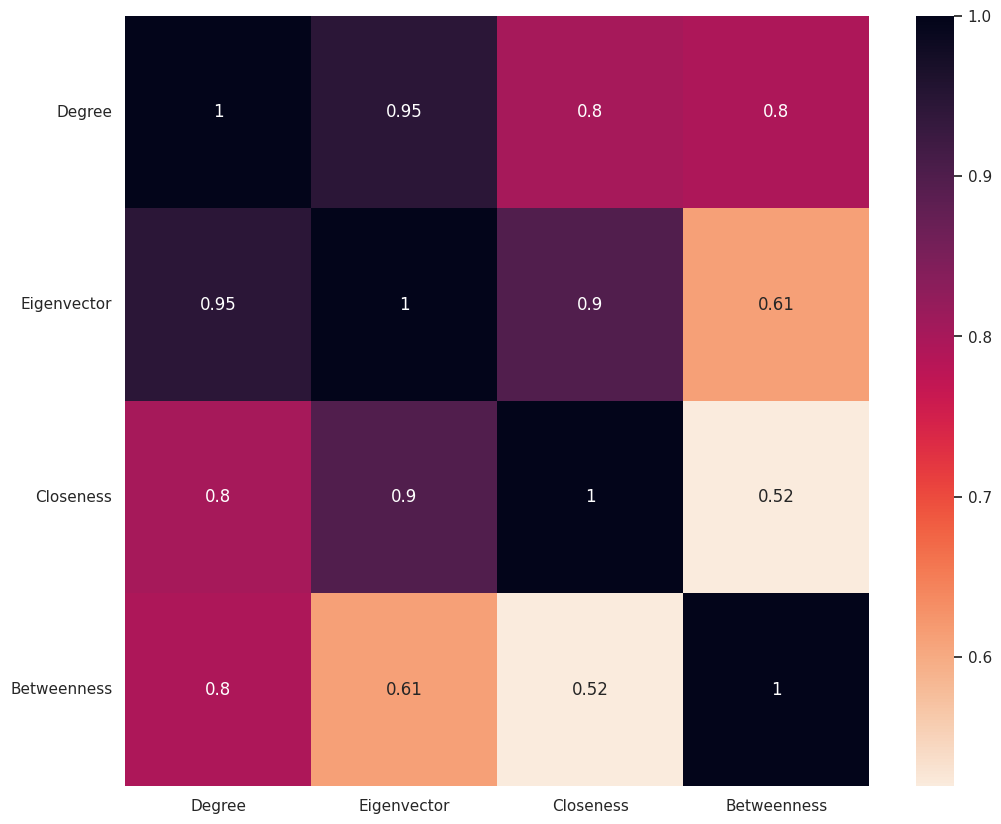

In [71]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(data=corr,
            annot=True,
            cmap="rocket_r")

plt.xticks(ticks=[x+0.5 for x in range(4)],
           labels=["Degree", "Eigenvector", "Closeness", "Betweenness"],
           rotation=0)
plt.yticks(ticks=[x+0.5 for x in range(4)],
           labels=["Degree", "Eigenvector", "Closeness", "Betweenness"],
           rotation=0)

plt.show()

## Bridges

In [72]:
num_bridges = len(list(nx.bridges(G,root=None)))
print(f"The graph has {num_bridges} bridges")
perc_bridge = num_bridges/G.number_of_edges()
print(f"{(perc_bridge * 100):.2f}% of all edges are bridges")

The graph has 62 bridges
2.40% of all edges are bridges


## Community detection

In [73]:
custom_params = {"axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)

In [74]:
communities = nx.community.louvain_communities(G, seed=42)
community_names = [f"Community {i + 1}" for i, _ in enumerate(communities)]
community_sizes = [len(c) for c in communities]
community_degrees = [np.mean(list(dict(G.degree(c)).values())) for c in communities]

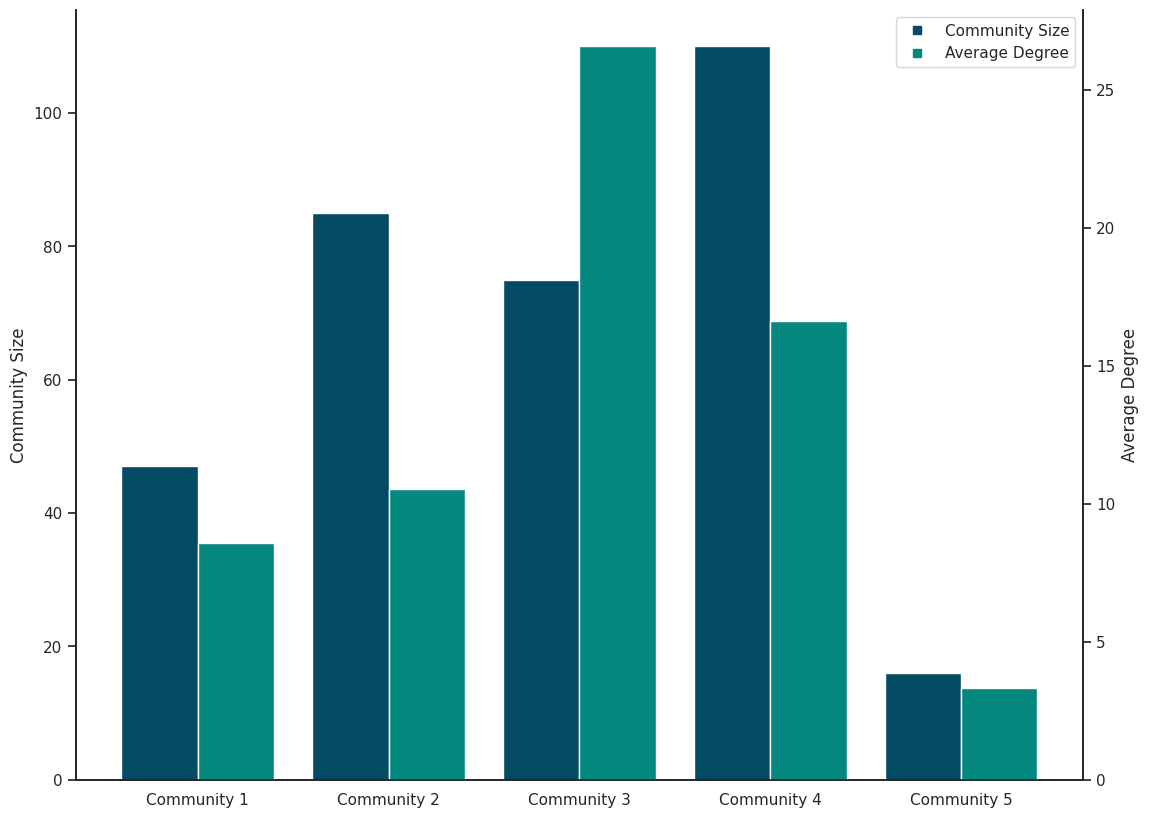

In [75]:
fig, ax = plt.subplots(figsize=(13, 10))

ax.set_xticks(ticks=range(1, 6),labels=community_names)

ax2 = ax.twinx()

ax.bar(x=[0.8, 1.8, 2.8, 3.8, 4.8],
       height=community_sizes,
       color="#034b63",
       width=0.4)

ax.set_ylabel("Community Size")

ax2.bar(x=[1.2, 2.2, 3.2, 4.2, 5.2],
        height=community_degrees,
        color="#04877e",
        width=0.4)

ax2.set_ylabel("Average Degree")

label_1 = mlines.Line2D([], [],
                        color="#034b63",
                        marker="s",
                        ls="",
                        label="Community Size")

label_2 = mlines.Line2D([], [],
                        color="#04877e",
                        marker="s",
                        ls="",
                        label="Average Degree")

ax.legend(handles=[label_1, label_2])

plt.show()

In [76]:
community_top_degrees = list()

for c in communities:
  c_degrees = list(sorted(dict(G.degree(c)).items(),
                          key=lambda x:x[1],
                          reverse=True))


  community_top_degrees.append(c_degrees[:3])

for i in range(len(communities)):

  print(f"Average degree in community {i+1}: "
        f"{community_degrees[i]:.2f}")

  print(f"The airports with the most connections in community {i+1} are:")

  for airport in community_top_degrees[i]:
    print(f"{airport[0]}: {airport[1]} connections")

  print("")

Average degree in community 1: 8.57
The airports with the most connections in community 1 are:
Dallas/Fort Worth, TX: 175 connections
Atlanta, GA: 143 connections
Baton Rouge, LA: 5 connections

Average degree in community 2: 10.52
The airports with the most connections in community 2 are:
Chicago, IL: 150 connections
Minneapolis, MN: 95 connections
Sanford, FL: 63 connections

Average degree in community 3: 26.56
The airports with the most connections in community 3 are:
Charlotte, NC: 115 connections
Washington, DC: 98 connections
New York, NY: 96 connections

Average degree in community 4: 16.60
The airports with the most connections in community 4 are:
Denver, CO: 154 connections
Phoenix, AZ: 122 connections
Las Vegas, NV: 116 connections

Average degree in community 5: 3.31
The airports with the most connections in community 5 are:
Anchorage, AK: 22 connections
Juneau, AK: 6 connections
Ketchikan, AK: 4 connections



## Assortativity

In [77]:
assortativity = nx.degree_assortativity_coefficient(G, weight=None)
print(f"The graph has an assortativity value of {assortativity:.2f}")

The graph has an assortativity value of -0.50


## Transitivity

In [78]:
nx.transitivity(G)

0.3188104098743923

In [79]:
nx.average_clustering(G)

0.5843615191578213

## Machine Learning

In [80]:
df_2008, routes_2008 = load_dataset("/content/drive/MyDrive/NetworkScience/flight_data/flights_2008.csv")
df_2023, _ = load_dataset("/content/drive/MyDrive/NetworkScience/flight_data/flights_2023.csv")

G_2008 = create_graph(df_2008)
G_2023 = create_graph(df_2023, excluded_routes=routes_2008)

print(G_2008)
print(G_2023)

G_train = G_2008
G_test = G_2023

X, y = create_link_prediction_data(G_train, G_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Graph with 283 nodes and 2241 edges
Graph with 280 nodes and 969 edges
Number of newly formed links: 698


### Gradient Boosting


In [81]:
ct = ColumnTransformer([
    ("StandardScaler", StandardScaler(),
     ["jaccard", "rai","aai","pref", "cnc"])])

gboost_predictor = Pipeline([
    ("Preproccesser", ct),
    ("Classifier", GradientBoostingClassifier())])

gboost_predictor.fit(X_train, y_train)

y_predicted = gboost_predictor.predict(X_test)

print("Gradient Boosting Results")
print(f"Accuracy: {accuracy_score(y_test, y_predicted):.2f}")
print(f"Precision: {precision_score(y_test, y_predicted):.2f}")
print(f"Recall: {recall_score(y_test, y_predicted):.2f}")
print(f"F1: {f1_score(y_test, y_predicted):.2f}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_predicted)}\n")

Gradient Boosting Results
Accuracy: 0.86
Precision: 0.85
Recall: 0.90
F1: 0.87
Confusion Matrix: 
[[108  24]
 [ 15 133]]



In [82]:
gb_metrics = [accuracy_score(y_test, y_predicted), precision_score(y_test, y_predicted), recall_score(y_test, y_predicted)]

### Logistic Regression

In [83]:
ct = ColumnTransformer([
    ("StandardScaler", StandardScaler(),
     ["jaccard", "rai","aai","pref", "cnc"])])

logistic_predictor = Pipeline([
    ("Preproccesser", ct),
    ("Classifier", LogisticRegression())])

logistic_predictor.fit(X_train, y_train)

y_predicted = logistic_predictor.predict(X_test)

print("Logistic Regression Results")
print(f"Accuracy: {accuracy_score(y_test, y_predicted):.2f}")
print(f"Precision: {precision_score(y_test, y_predicted):.2f}")
print(f"Recall: {recall_score(y_test, y_predicted):.2f}")
print(f"F1: {f1_score(y_test, y_predicted):.2f}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_predicted)}\n")

Logistic Regression Results
Accuracy: 0.84
Precision: 0.86
Recall: 0.82
F1: 0.84
Confusion Matrix: 
[[113  19]
 [ 27 121]]



In [84]:
lr_metrics = [accuracy_score(y_test, y_predicted), precision_score(y_test, y_predicted), recall_score(y_test, y_predicted)]

Metrics Plot

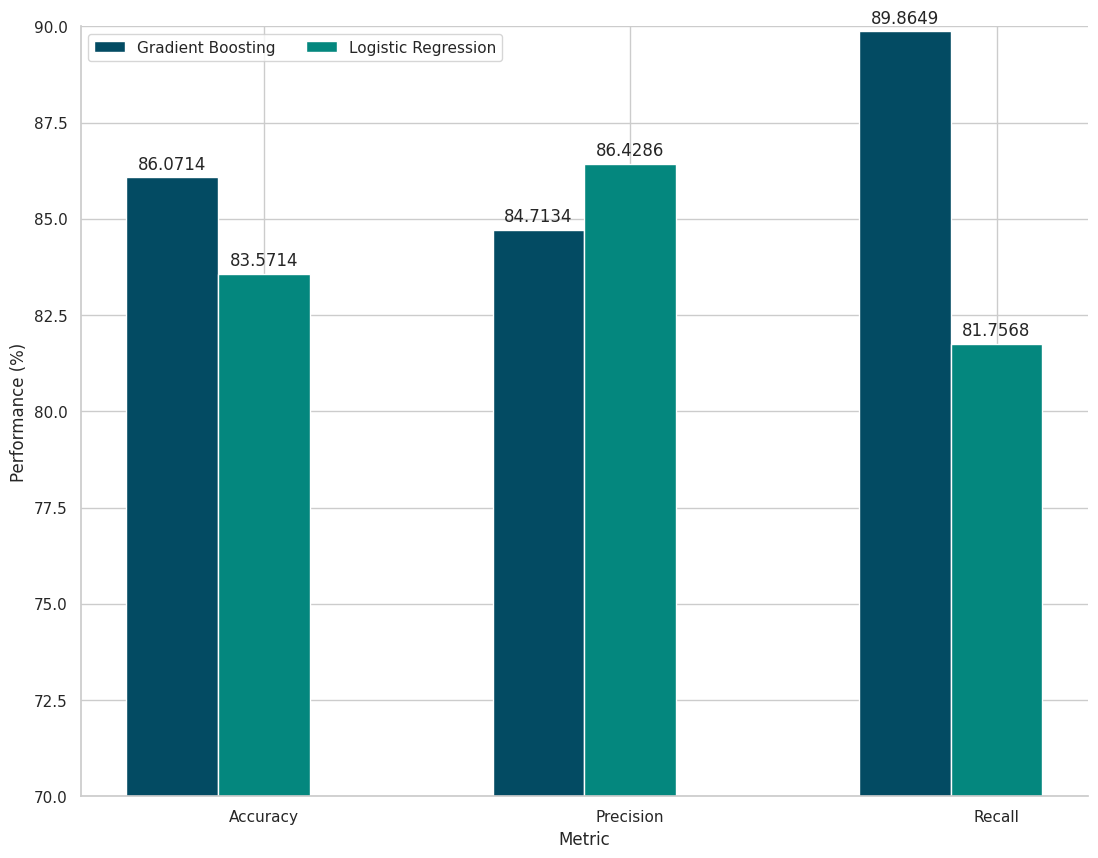

In [85]:
metrics = pd.DataFrame([gb_metrics, lr_metrics])
metrics.rename(columns={0:"Accuracy", 1:"Precision", 2:"Recall"}, inplace=True)
metrics["Model"] = ["Gradient Boost", "Logistic Regression"]

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

models_metrics = ("Accuracy", "Precision", "Recall")
models_performance = {
    "Gradient Boosting": metrics.iloc[0, 0:3] * 100,
    "Logistic Regression": metrics.iloc[1, 0:3] * 100,
}

x = np.arange(len(models_metrics))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(13,10))

for attribute, measurement in models_performance.items():
    offset = width * multiplier
    if attribute == "Gradient Boosting":
      rects = ax.bar(x + offset, measurement, width, label=attribute, color="#034b63")
    else:
      rects = ax.bar(x + offset, measurement, width, label=attribute, color="#04877e")

    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Performance (%)")
ax.set_xlabel("Metric")
ax.set_xticks(x + width, models_metrics)
ax.legend(loc='upper left', ncols=3)

ax.set_ylim(70, 90)

plt.show()

### Forecast: Possible Flight Connections in the Future

In [86]:
edge_list = np.array([{u,v} for u,v in G.edges()])

negative_datapoints = []
nodes_list = list(G.nodes())
count = 0
for count in range(1000):
  u, v = np.random.choice(nodes_list, size=2, replace=False)
  if not G.has_edge(u, v):
      negative_datapoints.append((u, v))

df_link_prediction =  pd.DataFrame()

# Feature engineering
df_link_prediction["jaccard"] = [j for _, _, j in nx.jaccard_coefficient(G, negative_datapoints)]
df_link_prediction["rai"] = [j for _, _, j in nx.resource_allocation_index(G, negative_datapoints)]
df_link_prediction["aai"] = [j for _, _, j in nx.adamic_adar_index(G, negative_datapoints)]
df_link_prediction["pref"] = [j for _, _, j in nx.preferential_attachment(G, negative_datapoints)]
df_link_prediction["cnc"] = [j for _, _, j in nx.common_neighbor_centrality(G, negative_datapoints)]
df_link_prediction["connection"] = negative_datapoints


In [87]:
X_forecast = df_link_prediction[["jaccard", "rai", "aai", "pref", "cnc"]]
y_forecast = gboost_predictor.predict_proba(X_forecast)
top_probs_ind = np.argsort(y_forecast[:, 1])[-5:]

In [88]:
y_forecast[top_probs_ind]

array([[0.05606499, 0.94393501],
       [0.05257457, 0.94742543],
       [0.04042964, 0.95957036],
       [0.03657282, 0.96342718],
       [0.02797418, 0.97202582]])

In [89]:
df_link_prediction["connection"][top_probs_ind]

727      (Punta Gorda, FL, Myrtle Beach, SC)
330     (Sacramento, CA, Raleigh/Durham, NC)
691    (Punta Gorda, FL, St. Petersburg, FL)
936             (Burbank, CA, San Diego, CA)
278         (Cincinnati, OH, Des Moines, IA)
Name: connection, dtype: object